# Replication Project: Global Forest Change Extended

**Replication Game – Berlin, 30 October 2025 Berlin**  

---

**Institut for Replication & Freie Universität Berlin**  

**Author:** [Dominik Bursy](mailto:dominik.bursy@icloud.com)  

**Last Updated:** October 2025

---

**Reference:**  
Berazneva, Julia, and Tanya S. Byker. 2017. *Does Forest Loss Increase Human Disease? Evidence from Nigeria.* American Economic Review, 107(5), 516–521. https://doi.org/10.1257/aer.p20171132

---

**Resources:**  
- [Guidelines on the Use of DHS GPS Data (English)](https://dhsprogram.com/publications/publication-SAR8-Spatial-Analysis-Reports.cfm)
- [Global Forest Change 2000–2014 Data Download](https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.2.html)
- [Global Forest Change 2000–2019 Data Download](https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html)

**Notes:**  
- EPSG:3857 is a spherical Mercator projected coordinate system in meters, ideal for web mapping applications like Google Maps, while EPSG:4326 is a geographic coordinate system in degrees using the WGS84 ellipsoid, which represents Earth as a 3D sphere and is used by GPS systems.
- To protect the confidentiality of respondents the geo-located data is displaced (Burgert et al., 2013). The displacement process moves the latitude and longitude to a new location under set parameters. Urban locations are displaced 0-2 kilometers while rural locations are displaced 0-5 kilometers with 1% (or every 100th point) displaced 0-10 kilometers.
- Nigeria spans four tiles. The code iterates through each row, checking whether the polygon overlaps with any of these tiles. For each match, it extracts annual forest loss, tree cover, and the corresponding pixel counts.

## Import Packages <a class="anchor" id="packages"></a>

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import rasterio
from rasterio.mask import mask
from shapely.geometry import box

In [2]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominikbursy/Documents/8_PhD_New/replication_game


---

## Import Data 

In [3]:
## Import DHS Dataframe being the base structure
gdf_dhs = gpd.read_file(f"{ROOT_FOLDER}/output/gdf_dhs.geojson")

In [4]:
## Create buffer as describe in Geolinking 

# Assume gdf is your GeoDataFrame in EPSG:4326
gdf_dhs = gdf_dhs.to_crs(epsg=3857)       # Web Mercator (units = meters)

# Buffer 5000 meters (5 km) for rural and Buffer 2000 meters (2 km) for urban areas 
gdf_dhs.loc[gdf_dhs["rural"] == 1, "geometry"] = gdf_dhs.loc[gdf_dhs["rural"] == 1].buffer(5000)
gdf_dhs.loc[gdf_dhs["rural"] == 0, "geometry"] = gdf_dhs.loc[gdf_dhs["rural"] == 0].buffer(2000)

# Buffer 5000 meters (5 km) for all areas
# gdf_dhs["geometry"] = gdf_dhs.buffer(5000)

# (Optional) convert back to WGS84
gdf_dhs = gdf_dhs.to_crs(epsg=4326)

## Forest Loss Year

A disaggregation of total forest loss to annual time scales. Encoded as either 0 (no loss) or else a value in the range 1–14, representing loss detected primarily in the year 2001–2014, respectively.

In [5]:
##### 1. List raster files #####
raster_paths = [
    f"{ROOT_FOLDER}/datasets/forest_change/lossyear_2019/Hansen_GFC-2019-v1.7_lossyear_10N_000E.tif",
    f"{ROOT_FOLDER}/datasets/forest_change/lossyear_2019/Hansen_GFC-2019-v1.7_lossyear_10N_010E.tif",
    f"{ROOT_FOLDER}/datasets/forest_change/lossyear_2019/Hansen_GFC-2019-v1.7_lossyear_20N_000E.tif",
    f"{ROOT_FOLDER}/datasets/forest_change/lossyear_2019/Hansen_GFC-2019-v1.7_lossyear_20N_010E.tif"
]

##### 2. Load polygons #####

# gdf = gdf_dhs[["caseid", "geometry_buffer"]].drop_duplicates()
# gdf = gdf.rename(columns={"geometry_buffer": "geometry"})
# gdf = gdf.to_crs(4326)

gdf = gdf_dhs.copy()

# Use CRS of first raster
with rasterio.open(raster_paths[0]) as src0:
    raster_crs = src0.crs

if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

##### 3. Process each polygon #####
results = []

for idx, row in gdf.iterrows():
    geom = [row.geometry.__geo_interface__]

    # Initialize record for this polygon
    record = {"geometry": row.geometry}
    for year in range(1, 20):
        record[f"forest_loss_{2000 + year}"] = 0
    record["forest_loss_size"] = 0

    # Loop through rasters
    for path in raster_paths:
        with rasterio.open(path) as src:
            raster_bbox = box(*src.bounds)

            # Skip if no intersection
            if not raster_bbox.intersects(row.geometry):
                continue

            try:
                out_image, out_transform = mask(src, geom, crop=True, all_touched=False) # all_touched=True
                masked_array = out_image[0]

                # Replace NoData with NaN
                if src.nodata is not None:
                    masked_array = np.where(masked_array == src.nodata, np.nan, masked_array)

                # Count values for each year
                for year in range(1, 20):
                    record[f"forest_loss_{2000 + year}"] += np.sum(masked_array == year)

                # Count valid pixels
                record["forest_loss_size"] += np.count_nonzero(~np.isnan(masked_array))

            except ValueError:
                # Polygon is completely outside this raster
                continue

    results.append(record)

##### 4. Convert results into GeoDataFrame #####
gdf_forest_loss = gpd.GeoDataFrame(results, crs=gdf.crs)

## Treecover

Tree cover in the year 2000, defined as canopy closure for all vegetation taller than 5m in height. Encoded as a percentage per output grid cell, in the range 0–100.

In [6]:
##### 1. List raster files #####
raster_paths = [
    f"{ROOT_FOLDER}/datasets/forest_change/lossyear_2019/Hansen_GFC-2019-v1.7_lossyear_10N_000E.tif",
    f"{ROOT_FOLDER}/datasets/forest_change/lossyear_2019/Hansen_GFC-2019-v1.7_lossyear_10N_010E.tif",
    f"{ROOT_FOLDER}/datasets/forest_change/lossyear_2019/Hansen_GFC-2019-v1.7_lossyear_20N_000E.tif",
    f"{ROOT_FOLDER}/datasets/forest_change/lossyear_2019/Hansen_GFC-2019-v1.7_lossyear_20N_010E.tif"
]

##### 2. Load polygons #####
# gdf = gdf_dhs[["caseid", "geometry_buffer"]].drop_duplicates()
# gdf = gdf.rename(columns={"geometry_buffer": "geometry"})
# gdf = gdf.to_crs(4326)
gdf = gdf_dhs.copy()

# Use CRS of first raster
with rasterio.open(raster_paths[0]) as src0:
    raster_crs = src0.crs

if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

##### 3. Process each polygon #####
results = []

for idx, row in gdf.iterrows():
    geom = [row.geometry.__geo_interface__]

    # Initialize record for this polygon
    record = {"geometry": row.geometry}
    record["treecover_mean"] = 0
    record["treecover_sum"] = 0

    # Loop through rasters
    for path in raster_paths:
        with rasterio.open(path) as src:
            raster_bbox = box(*src.bounds)

            # Skip if no intersection
            if not raster_bbox.intersects(row.geometry):
                continue

            try:
                out_image, out_transform = mask(src, geom, crop=True, all_touched=False) # all_touched=True
                masked_array = out_image[0]

                # Replace NoData with NaN
                if src.nodata is not None:
                    masked_array = np.where(masked_array == src.nodata, np.nan, masked_array)

                # Count values 
                record["treecover_mean"] += np.mean(masked_array)
                record["treecover_sum"] += np.sum(masked_array)

            except ValueError:
                # Polygon is completely outside this raster
                continue

    results.append(record)

##### 4. Convert results into GeoDataFrame #####
gdf_treecover = gpd.GeoDataFrame(results, crs=gdf.crs)

## Export Dataframe

In [7]:
## Merge forest_loss into DHS dataframe
gdf_dhs = gdf_dhs.join(gdf_forest_loss.drop(columns=["geometry"]))

## Merge treecover into DHS dataframe
gdf_dhs = gdf_dhs.join(gdf_treecover.drop(columns=["geometry"]))

In [8]:
## Revise treecover mean 
gdf_dhs["treecover_mean"] = gdf_dhs["treecover_sum"] / gdf_dhs["forest_loss_size"]

In [9]:
## Export Dataframe
gdf_dhs[[
    "caseid",
    "forest_loss_2001",
    "forest_loss_2002",
    "forest_loss_2003",
    "forest_loss_2004",
    "forest_loss_2005",
    "forest_loss_2006",
    "forest_loss_2007",
    "forest_loss_2008",
    "forest_loss_2009",
    "forest_loss_2010",
    "forest_loss_2011",
    "forest_loss_2012",
    "forest_loss_2013",
    "forest_loss_2014",
    "forest_loss_2015",
    "forest_loss_2016",
    "forest_loss_2017",
    "forest_loss_2018",
    "forest_loss_2019",
    "forest_loss_size",
    "treecover_mean"
]].to_csv(f"{ROOT_FOLDER}/output/dataframe_forest_change_2019.csv")

---

## Plot data

In [13]:
gdf_nigeria = gpd.read_file(f"{ROOT_FOLDER}/datasets/map_africa/nga_admbnda_adm2_osgof_20190417.shp")

gdf_nigeria = gdf_nigeria.reset_index(names="LGA")

gdf_nigeria = gdf_nigeria.sjoin(gdf_dhs, how="left")

In [14]:
gdf_nigeria["treecover_mean_cluster_mean"] = (
    gdf_nigeria.groupby(gdf_nigeria.index)["treecover_mean"]
    .transform("mean")
)

gdf_nigeria = gdf_nigeria.drop_duplicates("LGA")

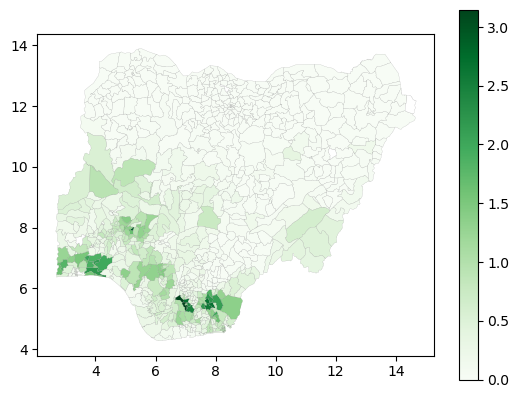

In [15]:
gdf_nigeria.plot(column="treecover_mean_cluster_mean", legend=True, cmap="Greens", edgecolor="grey", linewidth=0.1, missing_kwds={
        "color": "white",
        #"edgecolor": "red",
        #"hatch": "///",
        #"label": "Missing values",
    });

---